# Hypothesis testing

In [1]:
using Distributions
using Plots
using Random
Random.seed!(72968);

## Coin flipping experiment

Consider an experiment of flipping a coin $N \in \mathbb{N}$ times.

The coin lands head with probability $p \in [0, 1]$ and tail with probability $1-p$. Coin flips are mutually independent.

Let $X_i$ be the random variable that is equal to 1 if the $i$th coin lands head and 0 if it lands tail.

## Hypothesis test

We want to test if the coin is fair, i.e. if it has equal probability of landing head and tail.

Our **null hypothesis** is
$$H_0: p = 0.5.$$

We want to test this null hypothesis against the **alternative hypothesis**
$$
H_1: p \neq 0.5.
$$

To do this, we want to specify a rule that tells us under which of the possible observed outcomes should we reject the null hypothesis. Under all other outcomes, we do not reject the null hypothesis. Such a rule is called a **hypothesis test**.

Succintly, the test is specified by a subset, called the **rejection region**, of all possible outcomes. Note that even in our simple example, there are $2^N$ possibilities. It would be impractical to specify the rule by enumerating all the rejected outcomes. Instead, we often want to specify the rule using some kind of summary of the outcome.

## Counting the heads

To make things concrete, suppose we flip a coin $N = 10$ times.

One possible rule is to reject the null if we do not have head 5 times and tail the other 5 times. For conciseness, let us construct a new random variable, the share of heads in an experiment:
$$
S(X_1, \dots, X_{10})
    = \frac{1}{10} \sum_{i=1}^{10} X_i.
$$

Our rule is then to reject the null whenever the observed value of $S$ is not equal to 0.5.

> Rule 1: Reject if $S \neq 0.5$.

This rule is evidently not a very good one. We would often reject the null under this rule even when the coin is actually fair. We can be precise and calculate the probability of rejecting the null hypothesis under this rule when the null is in fact true. The probability of a hypothesis test rejecting the null when the null is true is called the **size** of the test and is often denoted by $\alpha$.

Note that $10S = \sum_{i=1}^{10} X_i$ follows a binomial distribution. Under the null hypothesis $p = 0.5$, its pmf is given by
$$
\Pr[10 S = k]
    = \binom{10}{k} 0.5^{10}
$$
for $k \in \{0, \dots, 10\}$.

Therefore, the size of our test is $\alpha = 1 - \binom{10}{5} 0.5^{10} \approx 0.754$.

In [2]:
rejectRule1(s) = (s != 0.5)
prRejectRule1(N, p) = 1 - ((N % 2 == 0) ? binomialPmf(Int(N / 2), N, p) : 0)
binomialPmf(k, N, p) = binomial(N, k) * p^k * (1-p)^(N-k)
print("Size of Rule 1 test: α = $(prRejectRule1(10, 0.5))")

Size of Rule 1 test: α = 0.75390625

In other words, our test would falsely reject the null hypothesis with 75.4% chance when it is in fact true!

We can also run simulated experiments to find the size. In each experiment, we flip a fair coin $N = 10$ times and calculate the share of heads, $S$. By running many such experiments, we can approximate the distribution of $S$ and calculate the percentage of experiments that reject the null hypothesis.

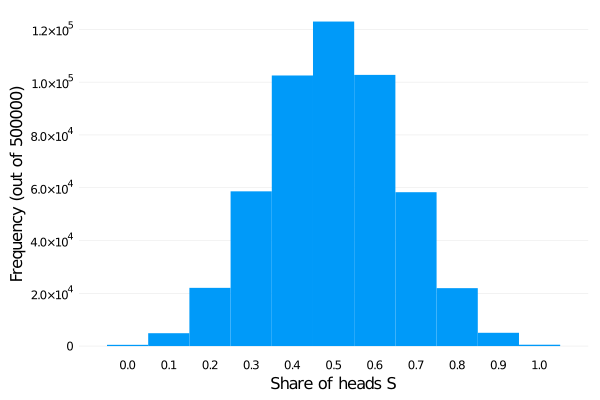

In [3]:
isHead(p) = (rand() < p)
headShare(N, p) = mean([isHead(p) for i in 1:N])
headShare(N, p, numExperiments) = [headShare(N, p) for t in 1:numExperiments]

function plotShareHistogram(N, experiment)
    δ = 1 / (2 * N)
    histogram(experiment, bins = N + 1,
        xlabel = "Share of heads S",
        ylabel = "Frequency (out of $(length(experiment)))",
        xticks = (δ:(1 / N):(N + δ), 0:(1 / N):1),
        framestyle = :grid,
        grid = :y,
        linewidth = 0,
        legend = :none,)
end

N = 10
p = 0.5
numExperiments = 500000
experiment = headShare(N, p, numExperiments)
plotShareHistogram(N, experiment)

In [4]:
rejectRate(experiment, rejectRule) = length(filter(rejectRule, experiment)) / length(experiment)
print("Size of Rule 1 test, simulation: α = $(rejectRate(experiment, rejectRule1))")

Size of Rule 1 test, simulation: α = 0.75409

## Formulating smaller tests

The problem with Rule 1 is that it is too stringent. Still, we have the right idea that the share of the heads should be close to one-half when the coin is fair. We can try modifying our rule so that we reject the null when $S$ is sufficiently far away from 0.5.

> Rule 2: Reject if $|S - 0.5| > c$, where $c \in [0,\infty)$.

Rule 2 in fact specifies a family of six different tests. When $c \in [0, 0.1)$, it is equivalent to Rule 1. When $c \in [0.1, 0.2)$, the test rejects if and only if the total number of heads is not equal to 4, 5, or 6. When $c \geq 0.5$, the test never rejects. The table below summarizes all the tests specified by Rule 2.

| Cutoff value $c$ | Test rejects when $S$ belongs to ... |
| ---------------- | ------------------------------------ |
| $[0, 0.1)$       | $\{0.5\}$                            |
| $[0.1, 0.2)$     | $\{0.4, 0.5, 0.6 \}$                 |
| $[0.2, 0.3)$     | $\{0.3, 0.4, 0.5, 0.6, 0.7 \}$       |
| $[0.3, 0.4)$     | $\{0.2, 0.3, \dots, 0.8 \}$          |
| $[0.4, 0.5)$     | $\{0.1, 0.2, \dots, 0.9 \}$          |
| $[0.5, \infty)$  | $\{0.0, 0.1, \dots, 1.0 \}$          |

Which $c$ should we use? To answer this question, it would be helpful to determine the size of the test associated with any given value of $c$. We have already seen that the size is $\alpha \approx 0.754$ when $c \in [0, 0.1)$. On the other end, the size is zero when $c \geq 0.5$ -- we will never reject the null when it is true. The problem is, of course, that this test never rejects the null, period. It always fails to reject the null even when it is false and therefore is rather useless as a test. Therefore, to determine which $c$ to use, we should examine not only the associated size, but also how often the corresponding test rejects the null when the null is false.

Before doing so, however, let us finish examining the relationship between $c$ and $\alpha$. Since we know the joint distribution of $(X_1, \dots, X_{10})$ under the null, we can calculate the size of the test for each $c$:
$$
\alpha(c)
    = \Pr[ |S-0.5| > c \mid p = 0.5]
    = 0.5^9 \sum_{k = \lfloor 10c + 5 \rfloor + 1}^{10} \binom{10}{k}.
$$
For example, the test with the cutoff value $c = 0.1$ has the size of $\alpha(0.1) \approx 0.344$.

In [5]:
rejectRule2(s, c) = (abs(s - 0.5) > c)
function prRejectRule2(N, p, c)
    Δ = 1 / N
    rejectRegion = Int.(floor.(N * filter(s -> rejectRule2(s, c), 0:Δ:1)))
    return sum([binomialPmf(k, N, p) for k in rejectRegion])
end
print("Size of Rule 2 test (c = 0.1): α = $(prRejectRule2(10, 0.5, 0.1))")

Size of Rule 2 test (c = 0.1): α = 0.34375

We can also make use of the simulated experiments to plot the size $\alpha(c)$ against the cutoff value $c$.

In [6]:
function cDiscreteValues(N)
    ϵ = 1 / (10 * N)
    Δ = 1 / N
    return ϵ:Δ:(0.5 + ϵ)
end

cPrint(c, N) = floor(c * N) / N

cDomainDiscrete = cDiscreteValues(N)
for c in cDomainDiscrete
    print("Size of Rule 2 test (c = $(cPrint(c, N))), simulation : α = $(rejectRate(experiment, s -> rejectRule2(s, c)))\n")
end

Size of Rule 2 test (c = 0.0), simulation : α = 0.75409
Size of Rule 2 test (c = 0.1), simulation : α = 0.343562
Size of Rule 2 test (c = 0.2), simulation : α = 0.109728
Size of Rule 2 test (c = 0.3), simulation : α = 0.021738
Size of Rule 2 test (c = 0.4), simulation : α = 0.001944
Size of Rule 2 test (c = 0.5), simulation : α = 0.0


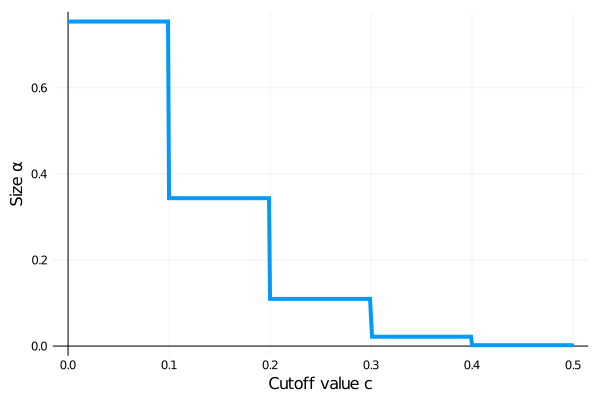

In [7]:
cDomainContinuous = 0:0.001:0.5
plot(cDomainContinuous, [rejectRate(experiment, s -> rejectRule2(s,c)) for c in cDomainContinuous],
    xlabel = "Cutoff value c",
    ylabel = "Size α",
    framestyle = :zerolines,
    linewidth = 4,
    legend = :none)

## Power

So far, we have discussed **type I error** which occurs when a test falsely rejects the null hypothesis when it is true. The size of a test is the probability of type I error. A test may also commit **type II error** which occurs when it fails to reject the null hypothesis when the alternative hypothesis is true. The **power** of a test is the probability it correctly rejects the null when the null is false, i.e. one minus the probability of type II error.

Our alternative hypothesis $H_1 : p \neq 0.5$ allows many different values of $p$. So it is not clear how to calculate the power -- which $p$ do we use? Instead, we define the **power function** of a test $\beta : [0,1] \to [0,1]$ defined by
$$
\beta(p) = \Pr[\text{test rejects the null} \mid p]
$$
where $\Pr[\text{event} \mid p]$ is the probability of the event when the coin lands on head with probability $p$. Note that the domain of the power function is the set of all possible values of the parameter of our interest, $p$.

The ideal test would have $\beta(p) = 0$ when $p$ satisfies the null hypothesis, i.e. $\beta(0.5) = 0$, and $\beta(p) = 1$ when $p$ satisfies the alternative hypothesis, i.e. $\beta(p) = 1 \; \forall p \neq 0.5$. In practice, no hypothesis testing problem has the ideal test.

Let us examine the power function of the test given by Rule 1. The pmf of $10 S$ is
$$
\Pr[10 S = k]
    = \binom{10}{k} p^k (1-p)^{10-k}
$$
for $k \in \{0, 1, \dots, 10\}$.

The power function of Rule 1 is therefore
$$
\beta(p)
    = 1 - \Pr[S = 0.5]
    = 1 - 252 p^5 (1-p)^5.
$$

We can similarly compute the power function for each of the six tests specified by Rule 2.

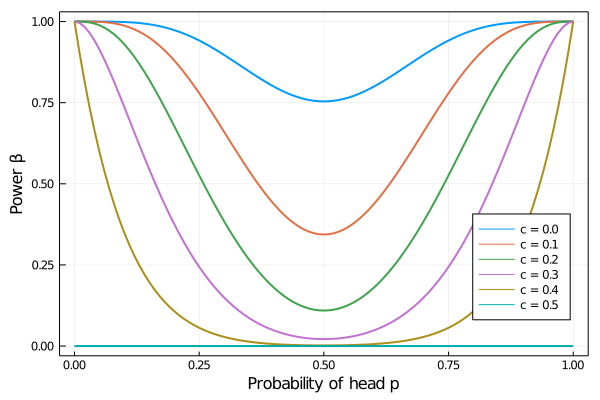

In [8]:
cDomainDiscrete = cDiscreteValues(N)
pDomain = 0:0.01:1
powerFunctionsPlot = plot(
    pDomain,
    [prRejectRule2(N, p, cDomainDiscrete[1]) for p in pDomain],
    xlabel = "Probability of head p",
    ylabel = "Power β",
    label = "c = 0.0",
    linewidth = 2,
    framestyle = :box,
    legend = :bottomright,)
for c in cDomainDiscrete[2:end]
    plot!(pDomain, [prRejectRule2(N, p, c) for p in pDomain],
        linewidth = 2, label = "c = $(cPrint(c, N))",)
end
powerFunctionsPlot

The plot of the power functions reveals that there is in fact no "best" choice of the cutoff $c$. Higher the cutoff $c$, lower the power of the test at all values of $p \in [0,1]$. On the one hand, this is good because the test has lower size (i.e. has lower type I error rate), but on the other hand, it comes at the cost of higher type II error rate.